# SAM review : Figure 4

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
import cftime
import itertools
import netCDF4
import cmaps
import sacpy as scp
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import BoundaryNorm
import cartopy.feature as cfeature   # to fill coastlines. 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns

# 1) Get data

###  Net-zero emission runs

In [11]:
def calculate_SAM_stabilisation_index(df, df_hist):
    # calculate mean at 40°S
    zm_msl_40S = df.sel(lat=-40.0, method='nearest').mean(dim='lon')
    # calculate mean at 65°S
    zm_msl_65S = df.sel(lat=-65.0, method='nearest').mean(dim='lon')
   
    # Climatology is 1981-2010 from hist run
    df_hist = df_hist.sel(time=slice('1981','2010'))
    
    zm_hist_40S = df_hist.sel(lat=-40.0, method='nearest').mean(dim='lon')
    zm_hist_40S_clim = zm_hist_40S.groupby('time.month').mean('time')
    zm_hist_40S_std = zm_hist_40S.groupby('time.month').std('time')
    
    zm_hist_65S = df_hist.sel(lat=-65.0, method='nearest').mean(dim='lon')
    zm_hist_65S_clim = zm_hist_65S.groupby('time.month').mean('time')
    zm_hist_65S_std = zm_hist_65S.groupby('time.month').std('time')
       
    # normalise the SAM index
    S40_norm_1 = (zm_msl_40S.groupby('time.month') - zm_hist_40S_clim) 
    S40_norm = S40_norm_1.groupby('time.month') / zm_hist_40S_std
    S65_norm_1 = (zm_msl_65S.groupby('time.month') - zm_hist_65S_clim)
    S65_norm = S65_norm_1.groupby('time.month') / zm_hist_65S_std

    # seems like the month dimension gets added with the groupby, so try and remove it..
    SAM = S40_norm - S65_norm
    SAM = SAM.drop_vars('month')
    return SAM

In [12]:
## Net-zero emission SAM (Andrew's experiment)

dir_data = '/g/data/ob22/as8561/data/enso_trans_stable/stable_runs/mslp_field/'
file1 = xr.open_dataset(dir_data+'mslp_PI-GWL-B2030.nc', decode_times=False).fld_s16i222.sel(lat=slice(-90,-30))
file2 = xr.open_dataset(dir_data+'mslp_PI-GWL-B2035_mon.nc', decode_times=False).fld_s16i222.sel(lat=slice(-90,-30))
file3 = xr.open_dataset(dir_data+'mslp_PI-GWL-B2040_mon.nc', decode_times=False).fld_s16i222.sel(lat=slice(-90,-30))
file4 = xr.open_dataset(dir_data+'mslp_PI-GWL-B2045_mon.nc', decode_times=False).fld_s16i222.sel(lat=slice(-90,-30))
file5 = xr.open_dataset(dir_data+'mslp_PI-GWL-B2050_mon.nc', decode_times=False).fld_s16i222.sel(lat=slice(-90,-30))
file6 = xr.open_dataset(dir_data+'mslp_PI-GWL-B2055_mon.nc', decode_times=False).fld_s16i222.sel(lat=slice(-90,-30))
file7 = xr.open_dataset(dir_data+'mslp_PI-GWL-B2060_mon.nc', decode_times=False).fld_s16i222.sel(lat=slice(-90,-30))

In [13]:
from cftime import DatetimeProlepticGregorian

def change_time_axis(df, start_date, end_date):
    # Generate the time axis with monthly steps
    new_time_axis = []
    current_date = start_date
    while current_date <= end_date:
        new_time_axis.append(current_date)
        if current_date.month == 12:
            current_date = cftime.DatetimeProlepticGregorian(current_date.year + 1, 1, 1)
        else:
            current_date = cftime.DatetimeProlepticGregorian(current_date.year, current_date.month + 1, 1)
    df_new = xr.DataArray(df, coords=[new_time_axis, df.lat, df.lon], dims=['time', 'lat','lon'])
    return df_new

psl1 = change_time_axis(file1, cftime.DatetimeProlepticGregorian(2030, 1, 1), cftime.DatetimeProlepticGregorian(3029, 12, 31))
psl2 = change_time_axis(file2, cftime.DatetimeProlepticGregorian(2035, 1, 1), cftime.DatetimeProlepticGregorian(3034, 12, 31))
psl3 = change_time_axis(file3, cftime.DatetimeProlepticGregorian(2040, 1, 1), cftime.DatetimeProlepticGregorian(3039, 12, 31))
psl4 = change_time_axis(file4, cftime.DatetimeProlepticGregorian(2045, 1, 1), cftime.DatetimeProlepticGregorian(3044, 12, 31))
psl5 = change_time_axis(file5, cftime.DatetimeProlepticGregorian(2050, 1, 1), cftime.DatetimeProlepticGregorian(3049, 12, 31))
psl6 = change_time_axis(file6, cftime.DatetimeProlepticGregorian(2055, 1, 1), cftime.DatetimeProlepticGregorian(3054, 12, 31))
psl7 = change_time_axis(file7, cftime.DatetimeProlepticGregorian(2060, 1, 1), cftime.DatetimeProlepticGregorian(3059, 12, 31))

In [14]:
## ACCESS-ESM1-5 native grid data
## ACCESS-ESM1-5 (hist and ssp585) in emission driver mode (esm-SSP585) 10th member:
psl_ACCESS_hist = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/esm-hist/r10i1p1f1/Amon/psl/gn/latest/psl_Amon_ACCESS-ESM1-5_esm-hist_r10i1p1f1_gn_185001-201412.nc', decode_times=True).psl
psl_ACCESS_ssp = xr.open_dataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-ssp585/r10i1p1f1/Amon/psl/gn/latest/psl_Amon_ACCESS-ESM1-5_esm-ssp585_r10i1p1f1_gn_201501-210012.nc', decode_times=True).psl
psl_ACCESS = xr.concat([psl_ACCESS_hist, psl_ACCESS_ssp], dim='time')
SAM_ACCESS = calculate_SAM_index(psl_ACCESS.sel(time=slice('1950','2100')), '1981','2010')

In [15]:
SAM1 = calculate_SAM_stabilisation_index(psl1, psl_ACCESS)
SAM2 = calculate_SAM_stabilisation_index(psl2, psl_ACCESS)
SAM3 = calculate_SAM_stabilisation_index(psl3, psl_ACCESS)
SAM4 = calculate_SAM_stabilisation_index(psl4, psl_ACCESS)
SAM5 = calculate_SAM_stabilisation_index(psl5, psl_ACCESS)
SAM6 = calculate_SAM_stabilisation_index(psl6, psl_ACCESS)
SAM7 = calculate_SAM_stabilisation_index(psl7, psl_ACCESS)

In [16]:
SAM_ACCESS_yr = SAM_ACCESS.resample(time='1YS').mean('time')
SAM1_yr = SAM1.resample(time='1YS').mean('time')
SAM2_yr = SAM2.resample(time='1YS').mean('time')
SAM3_yr = SAM3.resample(time='1YS').mean('time')
SAM4_yr = SAM4.resample(time='1YS').mean('time')
SAM5_yr = SAM5.resample(time='1YS').mean('time')
SAM6_yr = SAM6.resample(time='1YS').mean('time')
SAM7_yr = SAM7.resample(time='1YS').mean('time')

### DAMIP trends

In [17]:
## Whisker plot for trends

mmmfile = pd.read_csv('/g/data/eg3/gab563/data/mmm_trend.csv')
modelfile = pd.read_csv('/g/data/eg3/gab563/data/model-mean_trend.csv')
#test = pd.read_excel(file_abram,  names=['Year', 'D17', 'A14', 'DJF', 'D17_DJF', 'K23'], header=1)
modelfile

,model,forcing,season,period,estimate,se,df,expand
0,BCC.1,hist-GHG,DJF,`1979--1999`,-0.006673,0.015686,34,2.032245
1,BCC.1,hist-GHG,DJF,`2000--2014`,-0.009876,0.020359,34,2.032245
2,BCC.1,hist-GHG,JJA,`1979--1999`,-0.002869,0.014714,33,2.034515
3,BCC.1,hist-GHG,JJA,`2000--2014`,0.010148,0.020590,33,2.034515
4,CAS.1,hist-GHG,DJF,`1979--1999`,0.021618,0.014775,34,2.032245
...,...,...,...,...,...,...,...,...
299,TaiESM1,historical,JJA,`2000--2014`,0.043790,0.032878,33,2.034515
300,UKESM1-0-LL,historical,DJF,`1979--1999`,0.122580,0.013567,34,2.032245
301,UKESM1-0-LL,historical,DJF,`2000--2014`,0.000847,0.017610,34,2.032245
302,UKESM1-0-LL,historical,JJA,`1979--1999`,-0.007562,0.009392,33,2.034515


In [18]:
model_mean_trend_df = pd.read_csv('/g/data/eg3/gab563/data/model-mean_trend.csv')
mmm_trend_df = pd.read_csv('/g/data/eg3/gab563/data/mmm_trend.csv')

# Display the first few rows of each dataframe to understand their structure
model_mean_trend_df.head(), mmm_trend_df.head()


(   model   forcing season        period  estimate        se  df    expand
 0  BCC.1  hist-GHG    DJF  `1979--1999` -0.006673  0.015686  34  2.032245
 1  BCC.1  hist-GHG    DJF  `2000--2014` -0.009876  0.020359  34  2.032245
 2  BCC.1  hist-GHG    JJA  `1979--1999` -0.002869  0.014714  33  2.034515
 3  BCC.1  hist-GHG    JJA  `2000--2014`  0.010148  0.020590  33  2.034515
 4  CAS.1  hist-GHG    DJF  `1979--1999`  0.021618  0.014775  34  2.032245,
         forcing season        period  estimate        se  df    expand
 0      hist-GHG    DJF  `1979--1999` -0.005874  0.003565  34  2.032245
 1      hist-GHG    DJF  `2000--2014` -0.004061  0.004627  34  2.032245
 2      hist-GHG    JJA  `1979--1999`  0.006300  0.004091  33  2.034515
 3      hist-GHG    JJA  `2000--2014`  0.002267  0.005726  33  2.034515
 4  hist-stratO3    DJF  `1979--1999`  0.006186  0.007639  34  2.032245)

In [19]:
# Define the desired order of 'period'
merged_df = pd.concat([model_mean_trend_df, mmm_trend_df])
desired_order = ['historical', 'hist-GHG', 'hist-stratO3']

# Convert 'period' to categorical with desired order
merged_df['forcing'] = pd.Categorical(merged_df['forcing'], categories=desired_order, ordered=True)



In [20]:
custom_palettes = {
    ('historical', '`1979--1999`','DJF'): ['lightgrey'],
    ('historical', '`2000--2014`','DJF'): ['darkgrey'],
    ('hist-GHG', '`1979--1999`','DJF'): ['indianred'],
    ('hist-GHG', '`2000--2014`','DJF'): ['firebrick'],
    ('hist-stratO3', '`1979--1999`','DJF'): ['lightgreen'],
    ('hist-stratO3', '`2000--2014`','DJF'): [ 'darkgreen'] 
}
unique_combinations = set(zip(merged_df['forcing'], merged_df['period']))
missing_combinations = unique_combinations - set(custom_palettes.keys())

for combination in missing_combinations:
    custom_palettes[combination] = ['grey']  # Example: Add default color for missing combination


# 2) PLOT

In [22]:
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
# Create a color map with a linear gradient around teal
start_color = 'azure'
end_color = 'darkcyan'
num_colors = 7
colors = [mcolors.to_rgb(start_color)]
for i in range(1, num_colors):
    # Calculate the interpolation factor
    interp_factor = i / (num_colors - 1)
    # Interpolate between start_color and end_color
    new_color = [(1 - interp_factor) * c1 + interp_factor * c2 for c1, c2 in zip(mcolors.to_rgb(start_color), mcolors.to_rgb(end_color))]
    colors.append(new_color)
cmap = mcolors.ListedColormap(colors)

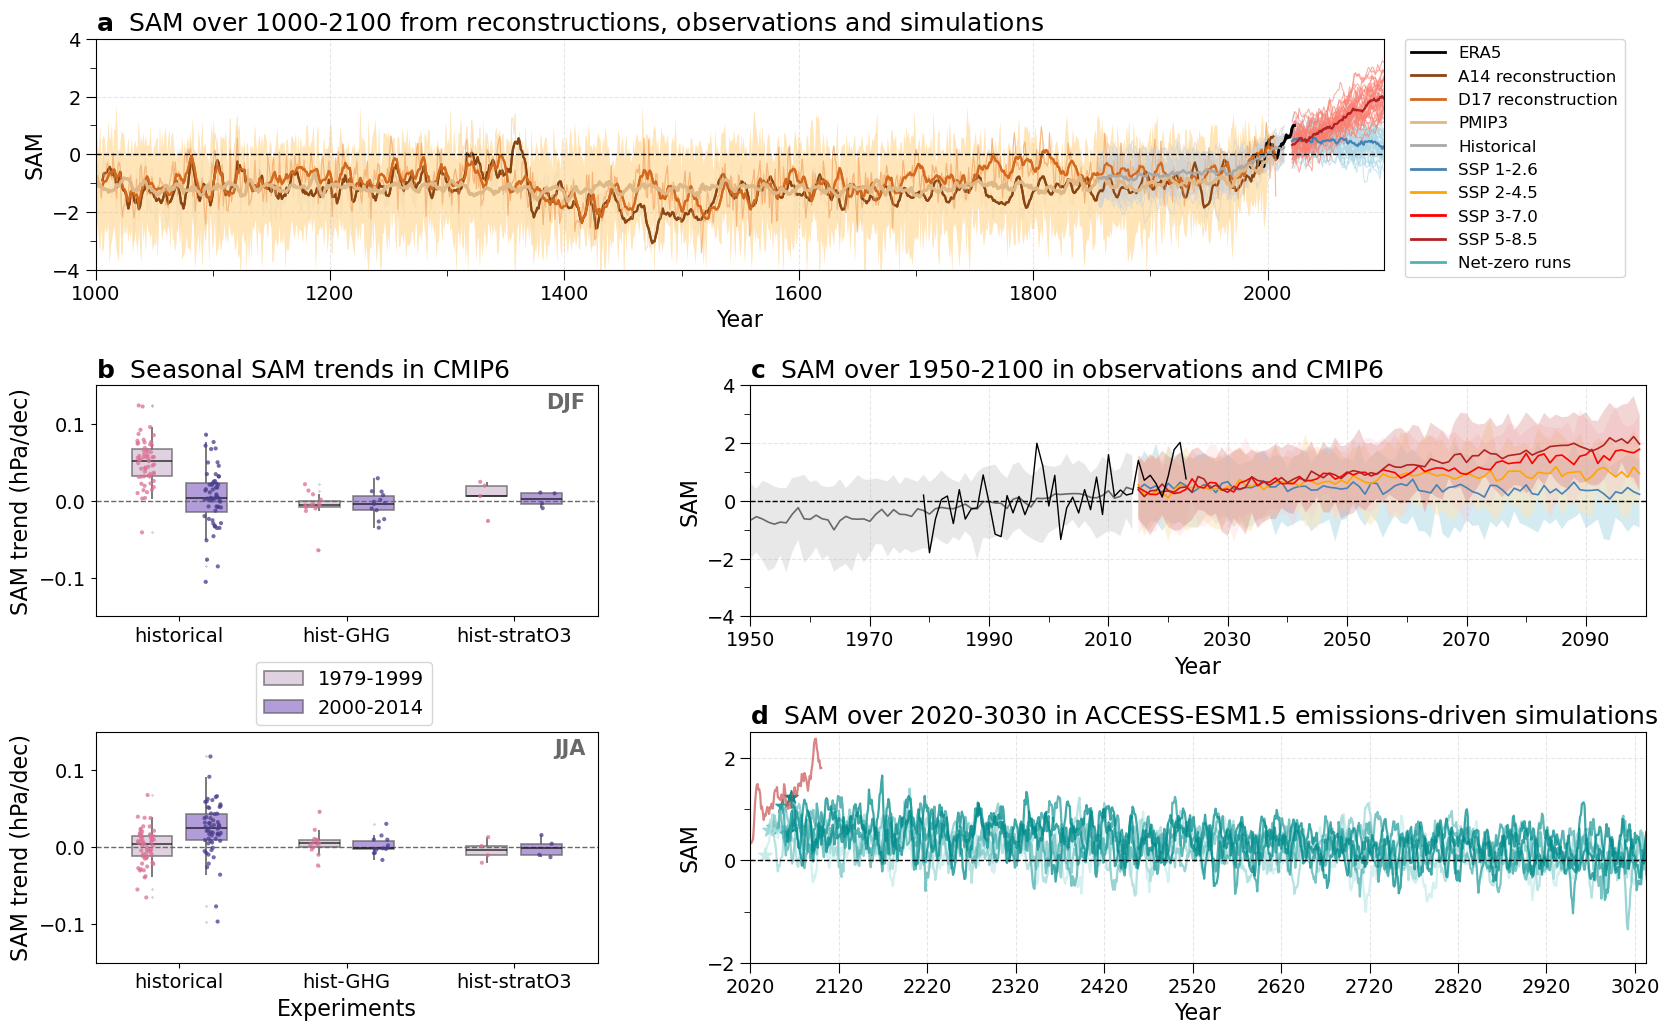

In [23]:
## NEW VERSION 


fig = plt.figure(figsize=(20, 12))

gs = fig.add_gridspec(ncols=12, nrows=3, figure=fig)

################################### PANEL 1 ############################################
# Create the first subplot spanning the entire width
ax1 = fig.add_subplot(gs[0, :10])
ax1.plot(var_obs.rolling(year=7).mean('year').year, var_obs.rolling(year=7).mean('year'), 'k', linewidth=2, label='ERA5')
ax1.plot(var_recon1.year, var_recon1, 'wheat', linewidth=0.75, alpha=0.5)
ax1.plot(var_recon1.rolling(year=7).mean('year').year, var_recon1.rolling(year=7).mean('year'), 'saddlebrown', linewidth=1.6, label='A14 reconstruction')
ax1.plot(var_recon2.year, var_recon2, 'sandybrown', linewidth=0.75, alpha=0.5)
ax1.plot(var_recon2.rolling(year=7).mean('year').year, var_recon2.rolling(year=7).mean('year'), 'chocolate', linewidth=1.6, label='D17 reconstruction')
ax1.plot(var_paleo.rolling(year=7).mean('year').year, var_paleo.median(dim='models').rolling(year=7).mean('year'), 'burlywood', linewidth=2.2, label='PMIP3')
ax1.fill_between(var_paleo.year, var_paleo.quantile(0.05, dim='models'), var_paleo.quantile(0.95, dim='models'), facecolor='moccasin', alpha=0.8)
for i in range(0, len(var_hist.models)):
    ax1.plot(var_hist.rolling(year=7).mean('year').year, var_hist.rolling(year=7).mean('year')[i, :], color='lightgrey', linewidth=0.75, alpha=0.65)
for i in range(0, len(var_126.models)):
    ax1.plot(var_126.rolling(year=7).mean('year').year, var_126.rolling(year=7).mean('year')[i, :], color='lightblue', linewidth=0.75, alpha=0.65)
for i in range(0, len(var_585.models)):
    ax1.plot(var_585.rolling(year=7).mean('year').year, var_585.rolling(year=7).mean('year')[i, :], color='salmon', linewidth=0.75, alpha=0.65)
ax1.plot(var_hist.rolling(year=7).mean('year').year, var_hist.rolling(year=7).mean('year').median(dim='models'), 'darkgray', linewidth=1.6, label='CMIP6 - Historical')
ax1.plot(var_126.rolling(year=7).mean('year').year, var_126.rolling(year=7).mean('year').median(dim='models'), 'steelblue', linewidth=1.6, label='CMIP6 - SSP 1-2.6')
ax1.plot(var_585.rolling(year=7).mean('year').year, var_585.rolling(year=7).mean('year').median(dim='models'), 'firebrick', linewidth=1.6, label='CMIP6 - SSP 5-8.5')
ax1.plot(var_obs.rolling(year=7).mean('year').year, var_obs.rolling(year=7).mean('year'), 'k', linewidth=2)
ax1.plot(var_recon1.year, var_recon1, 'wheat', linewidth=0.75, alpha=0.5)
ax1.plot(var_recon1.rolling(year=7).mean('year').year, var_recon1.rolling(year=7).mean('year'), 'saddlebrown', linewidth=1.6)
ax1.plot(var_recon2.year, var_recon2, 'sandybrown', linewidth=0.75, alpha=0.5)
ax1.plot(var_recon2.rolling(year=7).mean('year').year, var_recon2.rolling(year=7).mean('year'), 'chocolate', linewidth=1.6)
ax1.plot(var_paleo.rolling(year=7).mean('year').year, var_paleo.median(dim='models').rolling(year=7).mean('year'), 'burlywood', linewidth=2.2)
ax1.fill_between(var_paleo.year, var_paleo.quantile(0.05, dim='models'), var_paleo.quantile(0.95, dim='models'), facecolor='moccasin', alpha=0.8)
ax1.plot(var_hist.rolling(year=7).mean('year').year, var_hist.rolling(year=7).mean('year').median(dim='models'), 'darkgray', linewidth=1.6)
ax1.set_xticks(np.arange(0, 2200, 200))
ax1.set_xticks(np.arange(0, 2150, 100), minor=True)
ax1.set_ylim([-4, 4])
ax1.set_yticks(np.arange(-4, 4.1, 2))
ax1.set_yticks(np.arange(-4, 4.1, 1), minor=True)
ax1.axhline(0, color='k', linestyle='--', linewidth=1)
ax1.set_title(r'$\bf{a}$  SAM over 1000-2100 from reconstructions, observations and simulations', loc='left', fontsize=18)
ax1.set_ylabel("SAM", fontsize=16)
ax1.set_xlabel("Year", fontsize=16)
ax1.set_xlim(var_recon1.rolling(year=7).mean('year').year[0], var_585.rolling(year=7).mean('year').year[-1])
ax1.tick_params(which='minor', labelsize=14, length=4)
ax1.tick_params(which='major', labelsize=14, length=7)
ax1.grid(which='major', alpha=0.3, linestyle='dashed')
ax1.legend(handles=[
    Line2D([], [], color='black', linewidth=2, label='ERA5'),
    Line2D([], [], color='saddlebrown', linewidth=2,label='A14 reconstruction'),
    Line2D([], [], color='chocolate', linewidth=2, label='D17 reconstruction'),
    Line2D([], [], color='burlywood', linewidth=2, label='PMIP3'),
    Line2D([], [], color='darkgray', linewidth=2, label='Historical'),
    Line2D([], [], color='steelblue', linewidth=2, label='SSP 1-2.6'),
    Line2D([], [], color='orange', linewidth=2, label='SSP 2-4.5'),
    Line2D([], [], color='red', linewidth=2, label='SSP 3-7.0'),
    Line2D([], [], color='firebrick', linewidth=2, label='SSP 5-8.5'),
    Line2D([], [], color=cmap(4 / 7), linewidth=2, label='Net-zero runs'),
], loc='upper left', bbox_to_anchor=(1.01, 1.035), fontsize=12)

################################### PANEL 2 ############################################
ax2 = fig.add_subplot(gs[1,5:])
ax2.plot(var_hist.year, var_hist.mean(dim='models'), 'dimgray', linewidth=1.2, label='Historical')
ax2.fill_between(var_hist.year, var_hist.quantile(0.05, dim='models'), var_hist.quantile(0.95, dim='models'), facecolor='lightgrey', alpha=0.5)
ax2.plot(var_126.year, var_126.mean(dim='models'), 'steelblue', linewidth=1.2, label='SSP 1-2.6')
ax2.fill_between(var_126.year, var_126.quantile(0.05, dim='models'), var_126.quantile(0.95, dim='models'), facecolor='lightblue', alpha=0.5)
ax2.plot(var_245.year, var_245.mean(dim='models'), 'orange', linewidth=1.2, label='SSP 2-4.5')
ax2.fill_between(var_245.year, var_245.quantile(0.05, dim='models'), var_245.quantile(0.95, dim='models'), facecolor='moccasin', alpha=0.5)
ax2.plot(var_370.year, var_370.mean(dim='models'), 'red', linewidth=1.2, label='SSP 3-7.0')
ax2.fill_between(var_370.year, var_370.quantile(0.05, dim='models'), var_370.quantile(0.95, dim='models'), facecolor='pink', alpha=0.25)
ax2.plot(var_585.year, var_585.mean(dim='models'), 'firebrick', linewidth=1.2, label='SSP 5-8.5')
ax2.fill_between(var_585.year, var_585.quantile(0.05, dim='models'), var_585.quantile(0.95, dim='models'), facecolor='indianred', alpha=0.25)
ax2.plot(var_obs.year, var_obs, 'k', linewidth=1, label='ERA5')
ax2.set_title(r'$\bf{c}$  SAM over 1950-2100 in observations and CMIP6', loc='left', fontsize=18)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.set_xlim([1950, 2100])
ax2.grid(which='major', alpha=0.3, linestyle='dashed')
ax2.set_xticks(np.arange(1950, 2110, 20))
ax2.set_xticks(np.arange(1950, 2100, 10), minor=True)
ax2.set_ylim([-4, 4])
ax2.set_yticks(np.arange(-4, 4.1, 2))
ax2.set_yticks(np.arange(-4, 4.1, 1), minor=True)
ax2.set_ylabel("SAM", fontsize=16)
ax2.set_xlabel("Year", fontsize=16)
ax2.tick_params(which='minor', labelsize=14, length=4)
ax2.tick_params(which='major', labelsize=14, length=7)


################################### PANEL 3 ############################################
ax31 = fig.add_subplot(gs[1, :4])
ax32 = fig.add_subplot(gs[2, :4])
ax31.set_title(r'$\bf{b}$  Seasonal SAM trends in CMIP6', loc='left', fontsize=18)

box_palette = ['thistle', 'mediumpurple']
# DJF plot with dots
sns.boxplot(x="forcing", y="estimate", hue="period", data=merged_df[merged_df["season"] == "DJF"], 
            ax=ax31, showcaps=False, patch_artist=True, palette = box_palette,width=0.65, gap=0.25,
            flierprops=dict(marker='o', markersize=0.25, linestyle='none'),
            boxprops=dict(alpha=0.75,linewidth=1.2), 
            medianprops=dict(alpha=0.7, linewidth=1.2, color='k'),
            whiskerprops=dict(linewidth=1.2))
sns.stripplot(x="forcing", y="estimate", hue="period", 
              data=model_mean_trend_df[model_mean_trend_df["season"] == "DJF"], dodge=True, jitter=True, 
              marker='o', size=3, alpha=0.75, ax=ax31, palette=['palevioletred','darkslateblue'])
ax31.axhline(0, color='dimgrey', linestyle='--', linewidth=1)
ax31.text(0.975, 0.97, 'DJF', transform=ax31.transAxes, fontsize=15, color='dimgrey', fontweight='bold', ha='right', va='top')
ax31.set_ylim([-0.15,0.15])
ax31.set_xlabel('')
ax31.set_ylabel('SAM trend (hPa/dec)', fontsize=16)
ax31.tick_params(axis='x', labelsize=14)  # Font size for xticks labels
ax31.tick_params(axis='y', labelsize=14)  # Font size for yticks labels
ax31.legend_.remove()
# JJA plot with dots
sns.boxplot(x="forcing", y="estimate", hue="period", data=merged_df[merged_df["season"] == "JJA"], 
            ax=ax32, showcaps=False, patch_artist=True, palette = box_palette, width=0.65, gap=0.25,
            flierprops=dict(marker='o', markersize=0.25, linestyle='none'),
            boxprops=dict(alpha=0.75,linewidth=1.2), 
            medianprops=dict(alpha=0.7, linewidth=1.2, color='k'),
            whiskerprops=dict(linewidth=1.2))
sns.stripplot(x="forcing", y="estimate", hue="period", 
              data=model_mean_trend_df[model_mean_trend_df["season"] == "JJA"], dodge=True, jitter=True, 
              marker='o', size=3, alpha=0.75, ax=ax32, palette=['palevioletred','darkslateblue'])
ax32.axhline(0, color='dimgrey', linestyle='--', linewidth=1)
ax32.text(0.975, 0.97, 'JJA', transform=ax32.transAxes, fontsize=15, color='dimgrey', fontweight='bold', ha='right', va='top')
ax32.set_ylim([-0.15,0.15])
ax32.set_xlabel('Experiments', fontsize=16)
ax32.set_ylabel('SAM trend (hPa/dec)', fontsize=16)
ax32.legend_.remove()
ax32.tick_params(axis='x', labelsize=14)  
ax32.tick_params(axis='y', labelsize=14)  

# Adjust the legend
handles, labels = ax31.get_legend_handles_labels()
new_labels = ['1979-1999', '2000-2014']
ax31.legend(handles[:2], new_labels, loc='upper left', ncol=1,fontsize=14, bbox_to_anchor=(.3, -0.155))
ax31.set_position([0.93, 0.35, 0.55, 0.4])  # [left, bottom, width, height]
ax32.set_position([0.93, 0.05, 0.55, 0.25])  # [left, bottom, width, height]

################################### PANEL 4 ############################################
meantime = 7
ax4 = fig.add_subplot(gs[2,5:])
ax4.plot(SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2020','2100')).time,SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2020','2100')), color='indianred', linewidth=1.6, alpha=0.75, label='Historical and SSP 5-8.5')
ax4.plot(SAM1_yr.rolling(time=meantime).mean('time').time, SAM1_yr.rolling(time=meantime).mean('time'), color=cmap(1 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2030')
ax4.plot(SAM2_yr.rolling(time=meantime).mean('time').time, SAM2_yr.rolling(time=meantime).mean('time'), color=cmap(2 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2035')
ax4.plot(SAM3_yr.rolling(time=meantime).mean('time').time, SAM3_yr.rolling(time=meantime).mean('time'), color=cmap(3 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2040')
ax4.plot(SAM4_yr.rolling(time=meantime).mean('time').time, SAM4_yr.rolling(time=meantime).mean('time'), color=cmap(4 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2045')
ax4.plot(SAM5_yr.rolling(time=meantime).mean('time').time, SAM5_yr.rolling(time=meantime).mean('time'), color=cmap(5 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2050')
ax4.plot(SAM6_yr.rolling(time=meantime).mean('time').time, SAM6_yr.rolling(time=meantime).mean('time'), color=cmap(6 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2055')
ax4.plot(SAM7_yr.rolling(time=meantime).mean('time').time, SAM7_yr.rolling(time=meantime).mean('time'), color=cmap(7 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2060')
ax4.scatter(cftime.DatetimeProlepticGregorian(2030+6, 1, 1), SAM1_yr.rolling(time=meantime).mean('time')[6], marker='*', s=100, color=cmap(1 / 7))
ax4.scatter(cftime.DatetimeProlepticGregorian(2035+6, 1, 1), SAM2_yr.rolling(time=meantime).mean('time')[6], marker='*', s=100, color=cmap(2 / 7))
ax4.scatter(cftime.DatetimeProlepticGregorian(2040+6, 1, 1), SAM3_yr.rolling(time=meantime).mean('time')[6], marker='*', s=100, color=cmap(3/ 7))
ax4.scatter(cftime.DatetimeProlepticGregorian(2045+6, 1, 1), SAM4_yr.rolling(time=meantime).mean('time')[6], marker='*', s=100, color=cmap(4 / 7))
ax4.scatter(cftime.DatetimeProlepticGregorian(2050+6, 1, 1), SAM5_yr.rolling(time=meantime).mean('time')[6], marker='*', s=100, color=cmap(5 / 7))
ax4.scatter(cftime.DatetimeProlepticGregorian(2055+6, 1, 1), SAM6_yr.rolling(time=meantime).mean('time')[6], marker='*', s=100, color=cmap(6 / 7))
ax4.scatter(cftime.DatetimeProlepticGregorian(2060+6, 1, 1), SAM7_yr.rolling(time=meantime).mean('time')[6], marker='*', s=100, color=cmap(7 / 7))
ax4.set_title(r'$\bf{d}$  SAM over 2020-3030 in ACCESS-ESM1.5 emissions-driven simulations', loc='left', fontsize=18)
ax4.set_xlim([cftime.DatetimeProlepticGregorian(2020, 1, 1), cftime.DatetimeProlepticGregorian(3031, 12, 31)])
start_year = cftime.DatetimeProlepticGregorian(2020, 1, 1).year
end_year = cftime.DatetimeProlepticGregorian(3031, 12, 31).year
major_ticks = np.arange(start_year, end_year + 1, 100)
ax4.set_xticks([cftime.DatetimeProlepticGregorian(year, 1, 1) for year in major_ticks])
ax4.set_xticklabels([f'{year}' for year in major_ticks])
ax4.axhline(0, color='k', linestyle='--', linewidth=1)
ax4.grid(which='major', alpha=0.3, linestyle='dashed')
ax4.set_ylim([-1.75, 2.5])
ax4.set_yticks(np.arange(-2, 2.7, 2))
ax4.set_yticks(np.arange(-2, 2.7, 1), minor=True)
ax4.set_ylabel("SAM", fontsize=16)
ax4.set_xlabel("Year", fontsize=16)
ax4.tick_params(which='minor', labelsize=14, length=4)
ax4.tick_params(which='major', labelsize=14, length=7)

plt.subplots_adjust(hspace=0.5)
plt.savefig('SAM_annual_newJulie.png', dpi=300, bbox_inches='tight')